In [203]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
from scipy import interpolate
pd.set_option('display.max_columns', 5000)  # or 1000
pd.set_option('display.max_rows', 5000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GroupKFold, StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score

In [207]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
print('Input data of all the lakes can be found in Training data folder.')
filename = input('Input data file name (without .csv): ')
all_df = pd.read_csv(filename+'.csv',sep = '\t',parse_dates = ['Date'])

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Trainning data
Load training data (containing nutrient observations)
Lake name in short: Mueggelsee
Input data of all the lakes can be found in Training data folder.
Input data file name (without .csv): Mueggelsee_Observation_df_nowinter_classification2


Index(['Date', 'DO_bot', 'DO_sur', 'Bloom', 'MM', 'thermD', 'delT', 'U',
       'AirP', 'Hum', 'AirT', 'SWR', 'CC', 'Prec', 'Ice_d',
       'days from iceoff date', 'MLD', 'W', 'SRP', 'TotP', 'NH4', 'NO3', 'Si',
       'Chl', 'Inva_spe'],
      dtype='object')
Ice variables? (Y/N)Y
name of iceoff variable:days from iceoff date
Modify iceoff_day? (Y/N)Y
Name of ice duration variable:Ice_d
Modify iceoff_day? (Y/N)Y
Name of binary feature: Inva_spe
Name of binary feature: 
Ice categorization? (Y/N)Y


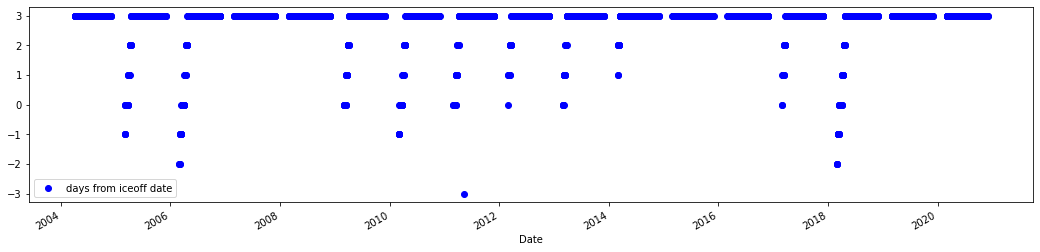

In [208]:
print(all_df.columns)
Ice_variable=input('Ice variables? (Y/N)')
if Ice_variable=='Y':
    ## Modifiy iceoff_day variable
    iceoff_name=input('name of iceoff variable:')

    def modify_iceoff_day(x,iceoff_name):
        if x[iceoff_name]>=30:
            return 3
        elif (x[iceoff_name]<30)&(x[iceoff_name]>=20):
            return 2
        elif (x[iceoff_name]<20)&(x[iceoff_name]>=10):
            return 1
        elif (x[iceoff_name]<10)&(x[iceoff_name]>=-10):
            return 0
        elif (x[iceoff_name]<-10)&(x[iceoff_name]>=-20):
            return -1
        elif (x[iceoff_name]<-20)&(x[iceoff_name]>=-30):
            return -2
        else:
            return -3

    modify=input('Modify iceoff_day? (Y/N)')
    if modify=='Y':
        all_df[iceoff_name]=all_df.apply(lambda x:modify_iceoff_day(x,iceoff_name), axis=1)

    ## categorize ice information
    all_df[['Date',iceoff_name]].plot(x='Date',y=iceoff_name,style='bo',figsize=(18,4))
    all_df[iceoff_name]=pd.Categorical(all_df[iceoff_name])

    ## Modifiy ice duration
    def modify_ice_d(x,ice_d_name):
        if x[ice_d_name]>60:
            return 'ice_d_long'
        elif (x[ice_d_name]<=60) & (x[ice_d_name]>30):
            return 'ice_d_middle'
        elif (x[ice_d_name]<=30) & (x[ice_d_name]>0):
            return 'ice_d_short'
        else:
            return 'no_ice_d'
    ice_d_name=input('Name of ice duration variable:')
    modify=input('Modify iceoff_day? (Y/N)')
    if modify=='Y':
        all_df[ice_d_name]=all_df.apply(lambda x:modify_ice_d(x,ice_d_name), axis=1)

    ## categorize ice information
    all_df[ice_d_name]=pd.Categorical(all_df[ice_d_name])

    ## Get variables dommies
    test_df=all_df.copy()
    while True:
        binary_f=input('Name of binary feature: ')
        if binary_f=='':
            break
        test_df[binary_f]=pd.Categorical(test_df[binary_f])
    Ice_c=input('Ice categorization? (Y/N)')
    if Ice_c=='Y':
        test_df=pd.concat([test_df,pd.get_dummies(test_df[[iceoff_name,ice_d_name]])],axis=1).drop([iceoff_name,ice_d_name],axis=1)              

In [223]:
print(test_df.columns)
n_feature = int(input('Number of daily features used for training: '))
features = []
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)
Daily_f=features.copy()

Index(['Date', 'DO_bot', 'DO_sur', 'Bloom', 'MM', 'thermD', 'delT', 'U',
       'AirP', 'Hum', 'AirT', 'SWR', 'CC', 'Prec', 'MLD', 'W', 'SRP', 'TotP',
       'NH4', 'NO3', 'Si', 'Chl', 'Inva_spe', 'days from iceoff date_-3',
       'days from iceoff date_-2', 'days from iceoff date_-1',
       'days from iceoff date_0', 'days from iceoff date_1',
       'days from iceoff date_2', 'days from iceoff date_3',
       'Ice_d_ice_d_long', 'Ice_d_ice_d_middle', 'Ice_d_ice_d_short',
       'Ice_d_no_ice_d'],
      dtype='object')
Number of daily features used for training: 22
Feature:thermD
Feature:U
Feature:AirP
Feature:Hum
Feature:AirT
Feature:SWR
Feature:CC
Feature:Prec
Feature:MLD
Feature:delT
Feature:W
Feature:Inva_spe
Feature:days from iceoff date_-2
Feature:days from iceoff date_-1
Feature:days from iceoff date_0
Feature:days from iceoff date_1
Feature:days from iceoff date_2
Feature:days from iceoff date_3
Feature:Ice_d_ice_d_long
Feature:Ice_d_ice_d_middle
Feature:Ice_d_ice_d_short
Fe

In [211]:
Nut_num = int(input('How many nutrients to predict? (put them in order) '))
Nut=[]
for i in range(Nut_num):
    Nut.append(input('Nut_'+str(i+1)+': '))

How many nutrients to predict? (put them in order) 1
Nut_1: NO3


# Random Forest Model

In [212]:
def find_best_params_RF(X,y,Classifier=True):
    param_grid = {'n_estimators':[int(x) for x in np.arange(100,500,10)],
             'max_depth':[int(x) for x in np.arange(2,10,1)],
             'min_samples_leaf':[int (x) for x in np.arange(2,10,2)]}

    if Classifier:
        Nut_rf = RandomForestClassifier(class_weight="balanced")#{0:17,1:3}
        RSgrid = RandomizedSearchCV(estimator = Nut_rf,param_distributions = param_grid,scoring='balanced_accuracy',
                                   n_iter = 20,cv = 10,verbose = 1,random_state=101)
    else:
        Nut_rf = RandomForestRegressor()
        RSgrid = RandomizedSearchCV(estimator = Nut_rf,param_distributions = param_grid,scoring='neg_mean_squared_error',
                           n_iter = 20,cv = 10,verbose = 1,random_state=101)

    RSgrid.fit(X,y)
    return RSgrid.best_params_,RSgrid.best_score_

Predict NO3
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 0.17
Model takes 2 min to run


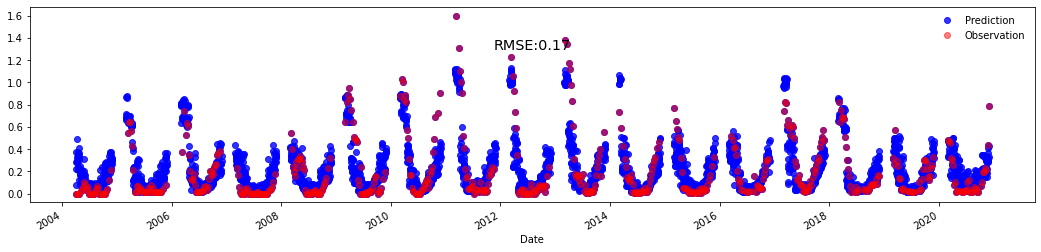

In [232]:
## Reconstruct the dataset for each nutrient variable
os.chdir(cd+'\\RandomForest for nutrient\\'+lakename)
start_time = time.time()
for i in range(len(Nut)):
    print('Predict '+Nut[i])
    f_list=['Date']+features+[Nut[i]]
    nona_df=test_df[f_list].dropna()
    ### Find the optimal hyperparameters based on the nonan dataset
    train_features=list(nona_df.columns)
    X=nona_df[[s for s in train_features if (s!='Date')&(s!=Nut[i])]]
    y=nona_df[Nut[i]]

    best_params,best_score =find_best_params_RF(X,y,Classifier=False)
        #print(best_params)
    print('RMSE: {}'.format(round(np.sqrt(-best_score),2)))

    ## Predict the nan value based on the best parameter set
    na_df=test_df[f_list].loc[test_df[f_list][Nut[i]].isna()].dropna(subset=features)
    Nut_rf = RandomForestRegressor().set_params(**best_params)
    Nut_rf.fit(X,y)
    test_X=na_df[[s for s in train_features if (s!='Date')&(s!=Nut[i])]]
    yhat=Nut_rf.predict(test_X)
    ## fill the predictive values back to the training dataset
    na_df[Nut[i]]=yhat
    test_df=pd.concat([nona_df,na_df],axis=0).sort_values(by='Date')
    f,ax=plt.subplots(figsize=(18,4))
    test_df.plot(x='Date',y=Nut[i],style='bo',alpha=0.8,ax=ax,label='Prediction')
    nona_df.plot(x='Date',y=Nut[i],style='ro',alpha=0.5,ax=ax,label='Observation')
    ax.legend(frameon=False)
    ax.text(0.5, 0.8, 'RMSE:{}'.format(round(np.sqrt(-best_score),2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax.transAxes,fontsize='x-large')
    f.savefig('RF predict '+Nut[i]+'.png',dpi=300)
    if i<len(Nut)-1:
        test_df=pd.concat([test_df,all_df[Nut[i+1]]],axis=1)
    features.append(Nut[i])
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')

In [239]:
features

['thermD',
 'U',
 'AirP',
 'Hum',
 'AirT',
 'SWR',
 'CC',
 'Prec',
 'MLD',
 'delT',
 'W',
 'Inva_spe',
 'days from iceoff date_-2',
 'days from iceoff date_-1',
 'days from iceoff date_0',
 'days from iceoff date_1',
 'days from iceoff date_2',
 'days from iceoff date_3',
 'Ice_d_ice_d_long',
 'Ice_d_ice_d_middle',
 'Ice_d_ice_d_short',
 'Ice_d_no_ice_d',
 'NO3']

In [242]:
importances = Nut_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Nut_rf.estimators_], axis=0)

In [244]:
std

array([0.01327495, 0.0182943 , 0.0164323 , 0.02859987, 0.09078516,
       0.02879497, 0.02066217, 0.00773831, 0.00717953, 0.02901021,
       0.0327484 , 0.02721194, 0.        , 0.        , 0.00093483,
       0.        , 0.00180209, 0.10524298, 0.01261396, 0.01299442,
       0.00301493, 0.01515508])

<AxesSubplot:>

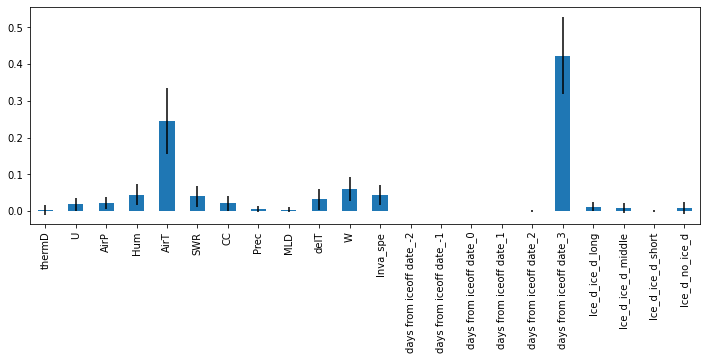

In [246]:
f,ax=plt.subplots(figsize=(12,4))
forest_importances = pd.Series(Nut_rf.feature_importances_, index=features[:-1])
forest_importances.plot.bar(yerr=std)

In [198]:
test_df.to_csv(lakename+'_RF_nutrient prediction.csv',sep='\t',index=False)

# Gradient Regressor Model

In [200]:
## Get variables dommies
test_df=all_df.copy()
while True:
    binary_f=input('Name of binary feature: ')
    if binary_f=='':
        break
    test_df[binary_f]=pd.Categorical(test_df[binary_f])
Ice_c=input('Ice categorization? (Y/N)')
if Ice_c=='Y':
    test_df=pd.concat([test_df,pd.get_dummies(test_df[[iceoff_name,ice_d_name]])],axis=1).drop([iceoff_name,ice_d_name],axis=1)              

Name of binary feature: Inva_spe
Name of binary feature: 
Ice categorization? (Y/N)Y


In [201]:
def find_best_params_GBR(X,y,Classifier=True):
    param_grid = {'n_estimators':[int(x) for x in np.arange(100,500,10)],
             'max_depth':[int(x) for x in np.arange(2,10,1)],
             'min_samples_leaf':[int (x) for x in np.arange(2,10,2)]}

    if Classifier:
        Nut_gbr = GradientBoostingClassifier(class_weight="balanced")#{0:17,1:3}
        RSgrid = RandomizedSearchCV(estimator = Nut_gbr,param_distributions = param_grid,scoring='balanced_accuracy',
                                   n_iter = 20,cv = 10,verbose = 1,random_state=101)
    else:
        Nut_gbr = GradientBoostingRegressor()
        RSgrid = RandomizedSearchCV(estimator = Nut_gbr,param_distributions = param_grid,scoring='neg_mean_squared_error',
                           n_iter = 20,cv = 10,verbose = 1,random_state=101)

    RSgrid.fit(X,y)
    return RSgrid.best_params_,RSgrid.best_score_

Predict NO3
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 0.17
Predict NH4
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 0.08
Predict SRP
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 63.12
Predict TotP
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 21.92
Predict Si
Fitting 10 folds for each of 20 candidates, totalling 200 fits
RMSE: 2.16


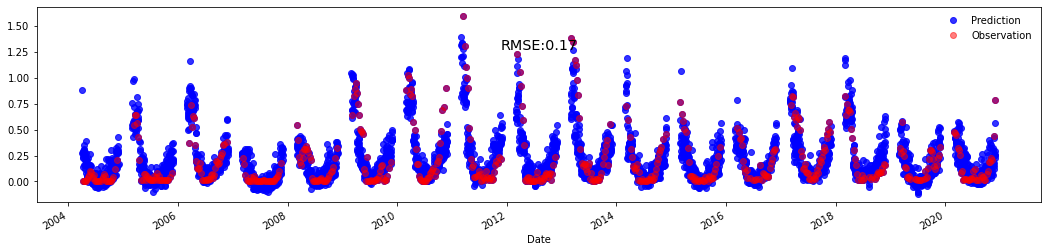

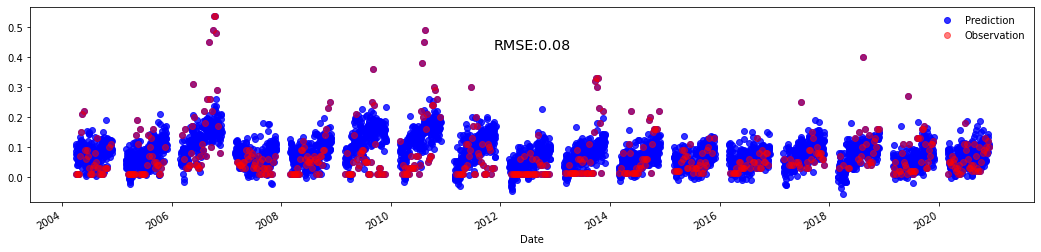

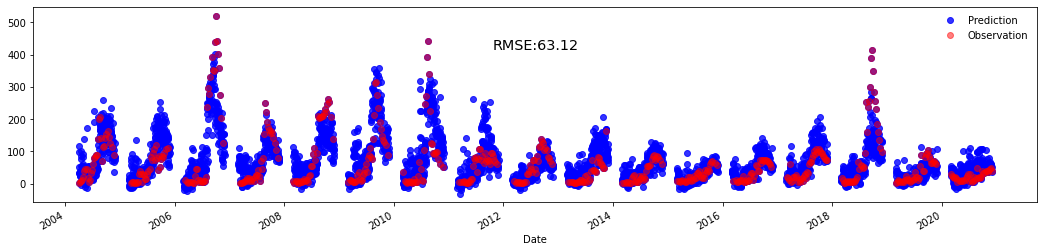

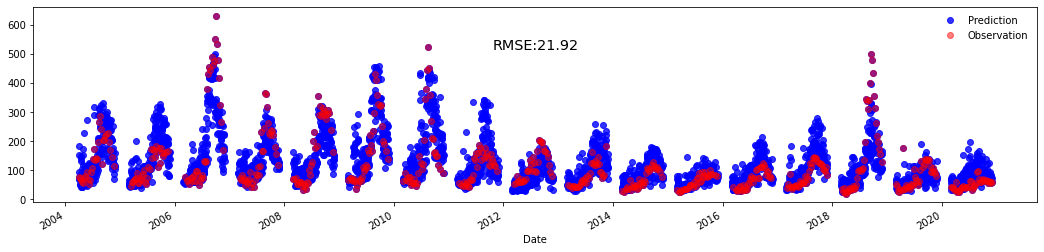

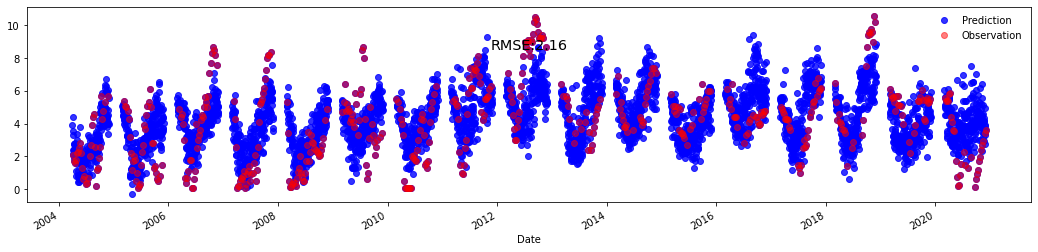

In [202]:
## Reconstruct the dataset for each nutrient variable
os.chdir(cd+'\\GradientBoosting for nutrient\\'+lakename)
for i in range(len(Nut)):
    print('Predict '+Nut[i])
    f_list=['Date']+Daily_f+[Nut[i]]
    nona_df=test_df[f_list].dropna()
    ### Find the optimal hyperparameters based on the nonan dataset
    train_features=list(nona_df.columns)
    X=nona_df[[s for s in train_features if (s!='Date')&(s!=Nut[i])]]
    y=nona_df[Nut[i]]

    best_params,best_score =find_best_params_GBR(X,y,Classifier=False)
        #print(best_params)
    print('RMSE: {}'.format(round(np.sqrt(-best_score),2)))

    ## Predict the nan value based on the best parameter set
    na_df=test_df[f_list].loc[test_df[f_list][Nut[i]].isna()]
    Nut_gbr = GradientBoostingRegressor().set_params(**best_params)
    Nut_gbr.fit(X,y)
    test_X=na_df[[s for s in train_features if (s!='Date')&(s!=Nut[i])]]
    yhat=Nut_gbr.predict(test_X)
    ## fill the predictive values back to the training dataset
    na_df[Nut[i]]=yhat
    test_df=pd.concat([nona_df,na_df],axis=0).sort_values(by='Date')
    f,ax=plt.subplots(figsize=(18,4))
    test_df.plot(x='Date',y=Nut[i],style='bo',alpha=0.8,ax=ax,label='Prediction')
    nona_df.plot(x='Date',y=Nut[i],style='ro',alpha=0.5,ax=ax,label='Observation')
    ax.legend(frameon=False)
    ax.text(0.5, 0.8, 'RMSE:{}'.format(round(np.sqrt(-best_score),2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax.transAxes,fontsize='x-large')
    f.savefig('RF predict '+Nut[i]+'.png',dpi=300)
    if i<len(Nut)-1:
        test_df=pd.concat([test_df,all_df[Nut[i+1]]],axis=1)
    Daily_f.append(Nut[i])